In [ ]:
import math
from math import floor, log2
from dimod import ConstrainedQuadraticModel, BinaryQuadraticModel, QuadraticModel
from dimod import Integer, Spin, Real
import numpy as np
import pickle
from dimod import SampleSet
from dwave.system import LeapHybridCQMSampler
import dwave.inspector

from numpy import arange, hstack, meshgrid, where

from matplotlib import pyplot
import matplotlib.pyplot as plt

import sys
from skimage.measure import block_reduce

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn



stdout = sys.stdout

In [2]:
class QNN_QUBO:

    def __init__(self, N=1, L=4, H=3, n=2, m=1, B=2, P=200):
        self.N, self.L = N, L
        self.H, self.n, self.m = H, n, m
        self.B, self.P = B, P

        self.cqm = ConstrainedQuadraticModel()


    def create_bounds(self):
        # Input layer decimal variables ranges
        self.b_1_lb = 0
        self.b_1_ub = 2 ** (floor(log2(self.n * (2 ** (self.B + 1))) + 1)) - 1

        self.s_1_lb = (-1) * self.n * (2 ** self.B)
        self.s_1_ub = (2 ** self.B) * self.n + self.b_1_ub - self.n * (2 ** self.B)

        self.r_1_lb = 0
        self.r_1_ub = 2 ** (floor(log2(3 * self.n * (2 ** self.B)) + 1)) - 1

        self.t_1_lb = 0
        self.t_1_ub = 2 ** (floor(log2(3 * self.n * (2 ** (self.B + 1))) + 1)) - 1

        # Hidden layer

        self.s_k_lb = -1
        self.s_k_ub = 2 ** (floor(log2(2 * self.H) + 1)) - 2

        self.r_k_lb = 0
        self.r_k_ub = 2 ** (floor(log2(2 * self.H) + 1)) - 1

        # Output layer
        self.w_L_lb = ( (-1)/ (self.H+1) ) * (2**self.B) 
        self.w_L_ub = ( 1 / (self.H+1) ) * (2**self.B) 


        self.b_L_lb = ( (-1)/ (self.H+1) ) * (2**self.B) 
        self.b_L_ub = ( 1 / (self.H+1) ) * (2**self.B) 
        self.y_lb = (-1) * 2 ** (self.B+1)
        self.y_ub = 2 ** (self.B+1)

    
    def create_variables(self, classification=True):
        # Crear las variables
        if classification:
            self.y_hat = [[Spin(f'y-hat_{i}_{m2}') for m2 in range(self.m)] for i in range(self.N)]
        else:
            self.y_hat = [[Integer(f'y-hat_{i}_{m2}', lower_bound=self.y_lb, upper_bound=self.y_ub) for m2 in range(self.m)] for i in range(self.N)]

        self.a = [[[Spin(f'a_{i}^({k}_{h})') for h in range(self.H)] for k in range(1, self.L-1)] for i in range(self.N)]

        self.s_1 = [[[Integer(f's_{i}^({1}_{h})', lower_bound=self.s_1_lb, upper_bound=self.s_1_ub) for h in range(self.H)]] for i in range(self.N)]
        self.s_k = [[[Integer(f's_{i}^({k}_{h})', lower_bound=self.s_k_lb, upper_bound=self.s_k_ub) for h in range(self.H)] for k in range(2, self.L-1)] for i in range(self.N)]
        self.s = [s1 + sk for s1, sk in zip(self.s_1, self.s_k)]

        self.b = [[Integer(f'b^({1})_{h}', lower_bound=self.b_1_lb, upper_bound=self.b_1_ub) for h in range(self.H)]]
        self.b_out = [[Integer(f'b^({self.L-1})_{m2}', lower_bound=self.b_L_lb, upper_bound=self.b_L_ub) for m2 in range(self.m)]]
        self.b += self.b_out


        self.W = [[[Spin(f'W^({1})_{h}_{n2}') for n2 in range(self.n)] for h in range(self.H)]]
        self.W_hidden = [[[Spin(f'W^({k})_{h}_{h2}') for h2 in range(self.H)] for h in range(self.H)] for k in range(2, self.L - 1)]
        self.W_out = [[[Integer(f'W^({self.L-1})_{h}_{m2}', lower_bound=self.w_L_lb, upper_bound=self.w_L_ub) for h in range(self.H)] for m2 in range(self.m)]]
        self.W += self.W_hidden + self.W_out


        self.r_1 = [[[Integer(f'r_{i}^({1})_{h}', lower_bound=self.r_1_lb, upper_bound=self.r_1_ub) for h in range(self.H)]] for i in range(self.N)]
        self.r_k = [[[Integer(f'r_{i}^({k})_{h}', lower_bound=self.r_k_lb, upper_bound=self.r_k_ub) for h in range(self.H)] for k in range(2, self.L - 1)] for i in range(self.N)]
        self.r = [r1 + rk for r1, rk in zip(self.r_1, self.r_k)]


        #t = [[Integer(f't_{i}^({1})_{h}', lower_bound=t_1_lb, upper_bound=t_1_ub) for h in range(H)] for i in range(N)]
        self.t = [[[Integer(f't_{i}^({k})_{h}', lower_bound=self.t_1_lb, upper_bound=self.t_1_ub) for h in range(self.H)] for k in range(1, self.L - 1)] for i in range(self.N)]

    def set_objective(self, y_data, multiplier=1):
        mse = [( multiplier * (y1 - y2)**2) for i in range(self.N) for y1, y2 in zip(y_data[i], self.y_hat[i]) ]
        print(mse)
        self.cqm.set_objective(sum(mse))


    def set_contraints(self, x_data):

        # Activacion 1
        # a * s = r
        for i in range(self.N):
            for k in range(self.L-2):
                for h in range(self.H):
                    self.cqm.add_constraint(self.a[i][k][h] * self.s[i][k][h] - self.r[i][k][h] == 0, label=f'Activacion1_{i}^({k}, {h})')
                    print(self.cqm.constraints[f'Activacion1_{i}^({k}, {h})'].to_polystring())


        # Activacion 2
        # a + 2*r = 1 + t
        for i in range(self.N):
            for k in range(self.L-2):
                for h in range(self.H):
                    self.cqm.add_constraint(self.a[i][k][h] + 2*self.r[i][k][h] - 1 - self.t[i][k][h] == 0, label=f'Activacion2_{i}^({k}, {h})')
                    print(self.cqm.constraints[f'Activacion2_{i}^({k}, {h})'].to_polystring())

        
        # input layer
        # Wx + b = s
        for i in range(self.N):
            for h in range(self.H):
                constraint = 0
                for n2 in range(self.n):
                    constraint += self.W[0][h][n2] * x_data[i][n2]
                self.cqm.add_constraint(constraint + self.b[0][h] - self.s[i][0][h] == 0, label=f'Topologia_input_{i}^(1, {h})')
                print(self.cqm.constraints[f'Topologia_input_{i}^(1, {h})'].to_polystring())

        # hidden layers
        # Wa + H - 1 = s
        for i in range(self.N):
            for k in range(1, self.L-2):
                for h in range(self.H):
                    constraint = 0
                    for h2 in range(self.H):
                        constraint += self.W[k][h][h2] * self.a[i][k-1][h2]
                    self.cqm.add_constraint(constraint + self.H - 1 - self.s[i][k][h] == 0, label=f'Topologia_hidden_{i}^({k}, {h})')
                    print(self.cqm.constraints[f'Topologia_hidden_{i}^({k}, {h})'].to_polystring())

        # Output layer
        # Wa + b = y
        for i in range(self.N):
            for m2 in range(self.m):
                constraint = 0
                for h in range(self.H):
                    constraint += self.W[self.L-2][m2][h] * self.a[i][self.L-3][h]
                
                self.cqm.add_constraint(constraint + self.b[1][m2] - self.y_hat[i][m2] == 0, label=f'Topologia_output_{i}^({self.L-2}, {m2})')
                print(self.cqm.constraints[f'Topologia_output_{i}^({self.L-2}, {m2})'].to_polystring())



In [3]:
class QNN():
    def __init__(self, s, activation='sign'):
        self.s = s
        self.w_in, self.w_hidden, self.w_out  = s.weights_in, s.weights_hidden, s.weights_out
        self.b_in, self.b_out = s.bias_in, s.bias_out
        self.activation = activation


    def activation(self, node):
        if self.activation == 'sign':
            if node >= 0:
                return 1
            else:
                return -1
        elif self.activation == 'abs':
            return abs(node)
        
        
    def predict(self, x_in):
        x = []

        n = self.s.qnn.n
        m = self.s.qnn.m
        L = self.s.qnn.L
        H = self.s.qnn.H
        
        for h in range(H):
            node = 0
            for n2 in range(n):
                node += self.w_in[h][n2] * x_in[n2]
            node += self.b_in[h]
            x.append(self.activation(node))
        
        
        for k in range(1, L-2):
            x_in = x
            x = []

            for h in range(H):
                node = 0
                for h2 in range(H):
                    node += self.w_hidden[k-1][h][h2] * x_in[h2]
                node += H - 1
                x.append(self.activation(node))
        x_in = x
        x = []
        for m2 in range(m):
            node = 0
            for h in range(H):
                node += self.w_out[m2][h] * x_in[h]
            node += self.b_out[m2]
            x.append(node)
        
        return x[0]
    
    def prediction_to_class(self, y_out):
        if y_out <= 2:
            return -1
        else:
            return 1
        

    def predict_array(self, input_data, to_class=True):
        res = []
        for x_ in input_data:
            if to_class:
                res.append(self.prediction_to_class(self.predict(x_)))
            else:
                res.append(self.predict(x_))
        
        return np.array(res)
    

    def plot_surface_decision(self, x_data, y_data):
        # generate dataset
        X, y = np.array(x_data), np.array(y_data).flatten
        # define bounds of the domain
        min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
        min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
        # define the x and y scale
        x1grid = arange(min1, max1, 0.1)
        x2grid = arange(min2, max2, 0.1)
        # create all of the lines and rows of the grid
        xx, yy = meshgrid(x1grid, x2grid)
        # flatten each grid to a vector
        r1, r2 = xx.flatten(), yy.flatten()
        r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
        # horizontal stack vectors to create x1,x2 input for the model
        grid = hstack((r1,r2))

        # make predictions for the grid
        yhat = self.predict_array(grid)
        # reshape the predictions back into a grid
        zz = yhat.reshape(xx.shape)
        # plot the grid of x, y and z values as a surface
        pyplot.contourf(xx, yy, zz, cmap='Paired')

        # show the plot
        x1_data = [i[0] for i in x_data]
        x2_data = [i[1] for i in x_data]
        y_map = [i[0] for i in y_data]

        pyplot.scatter(x1_data, x2_data, c=y_map)
        pyplot.show()

In [4]:
class Sample():

    def __init__(self, x_data, y_data, qnn=None, label = 'QNN'):
        self.N = len(x_data)
        self.x_data = x_data
        self.y_data = y_data
        self.label = label
        self.qnn = qnn

        if self.qnn is None:
            self.qnn = QNN_QUBO(N=self.N)

        self.sampleset = None

        TOKEN = ""
        self.sampler = LeapHybridCQMSampler(token=TOKEN)

    def create_qubo(self, verbose=False):
        self.qnn.create_bounds()
        self.qnn.create_variables()

        if verbose == True:
            file = open(self.label+'.txt', 'a')
            sys.stdout = file
        
        self.qnn.set_objective(self.y_data, 10)
        self.qnn.set_contraints(self.x_data)
        
        if verbose == True:
            sys.stdout = stdout
            file.close()
        
            
    
    def run(self):
        self.sampleset = self.sampler.sample_cqm(self.qnn.cqm,
                            time_limit=20,
                            label=self.label)
        
        self.save_sample()
        
    def process_samples(self):
        print("{} posibles soluciones de {}".format(
            self.sampleset.record.is_feasible.sum(), len(self.sampleset)
        ))
        self.feasibles  = self.sampleset.filter(lambda row: row.is_feasible)
        self.best = self.feasibles.first


    def save_sample(self):
        if self.sampleset is not None:
            fileName = self.label + ".pkl"
            with open(fileName, 'wb') as file:
                pickle.dump(self.sampleset.to_serializable(), file)


    def load_sample(self, fileName='test.pkl'):
        with open(fileName, 'rb') as file:
            self.sampleset = SampleSet.from_serializable(pickle.load(file))
        
    
    def decode_solution(self, solution=None):
        if (solution is None):
            solution = self.best

        self.weights_in = [[solution.sample[f'W^({1})_{h}_{n2}'] for n2 in range(self.qnn.n)] for h in range(self.qnn.H)]
        self.weights_hidden = [[[solution.sample[f'W^({k})_{h}_{h2}'] for h2 in range(self.qnn.H)] for h in range(self.qnn.H)] for k in range(2, self.qnn.L - 1)]
        self.weights_out = [[solution.sample[f'W^({self.qnn.L-1})_{h}_{m2}'] for h in range(self.qnn.H)] for m2 in range(self.qnn.m)]

        self.bias_in = [solution.sample[f'b^({1})_{h}'] for h in range(self.qnn.H)]
        self.bias_out = [solution.sample[f'b^({self.qnn.L-1})_{m2}'] for m2 in range(self.qnn.m)]

        return QNN(self)
        #return QNN(self.weights_in, self.weights_hidden, self.weights_out, self.bias_in, self.bias_out)

# Point Classification

In [194]:
x_data = [[-3, -3], 
        [-2, -3], 
        [-2, 0],
        [-3, -1],
        [0, -3],


        [2, 2], 
        [1, 3], 
        [3, 2], 
        [1, 1], 
        [0, 3]]

y_data = [[-1], [-1], [-1], [-1], [-1], [1], [1], [1], [1], [1]]


N = len(x_data)

In [206]:
qubo = QNN_QUBO(N=N, L=4, H=2, n=2, m=1, P=100)

In [207]:
s = Sample(x_data=x_data, y_data=y_data, qnn=qubo, label='QNN Classification 5 Complex')

In [208]:
s.create_qubo(verbose=True)

In [199]:
s.run()

In [209]:
s.load_sample('QNN Classification 5 Complex.pkl')

In [210]:
s.process_samples()

133 posibles soluciones de 148


In [201]:
s.best

Sample(sample={'W^(1)_0_0': 1.0, 'W^(1)_0_1': 1.0, 'W^(1)_1_0': -1.0, 'W^(1)_1_1': -1.0, 'W^(2)_0_0': -1.0, 'W^(2)_0_1': -1.0, 'W^(2)_1_0': 1.0, 'W^(2)_1_1': 1.0, 'W^(3)_0_0': 1.0, 'W^(3)_1_0': 1.0, 'a_0^(1_0)': 1.0, 'a_0^(1_1)': 1.0, 'a_0^(2_0)': -1.0, 'a_0^(2_1)': 1.0, 'a_1^(1_0)': 1.0, 'a_1^(1_1)': 1.0, 'a_1^(2_0)': -1.0, 'a_1^(2_1)': 1.0, 'a_2^(1_0)': 1.0, 'a_2^(1_1)': 1.0, 'a_2^(2_0)': -1.0, 'a_2^(2_1)': 1.0, 'a_3^(1_0)': 1.0, 'a_3^(1_1)': 1.0, 'a_3^(2_0)': -1.0, 'a_3^(2_1)': 1.0, 'a_4^(1_0)': 1.0, 'a_4^(1_1)': 1.0, 'a_4^(2_0)': -1.0, 'a_4^(2_1)': 1.0, 'a_5^(1_0)': 1.0, 'a_5^(1_1)': -1.0, 'a_5^(2_0)': 1.0, 'a_5^(2_1)': 1.0, 'a_6^(1_0)': 1.0, 'a_6^(1_1)': -1.0, 'a_6^(2_0)': 1.0, 'a_6^(2_1)': 1.0, 'a_7^(1_0)': 1.0, 'a_7^(1_1)': -1.0, 'a_7^(2_0)': 1.0, 'a_7^(2_1)': 1.0, 'a_8^(1_0)': 1.0, 'a_8^(1_1)': 1.0, 'a_8^(2_0)': -1.0, 'a_8^(2_1)': 1.0, 'a_9^(1_0)': 1.0, 'a_9^(1_1)': -1.0, 'a_9^(2_0)': 1.0, 'a_9^(2_1)': 1.0, 'b^(1)_0': 14.0, 'b^(1)_1': 2.0, 'b^(3)_0': -1.0, 'r_0^(1)_0': 8.0, 'r_

In [211]:
qnn = s.decode_solution()

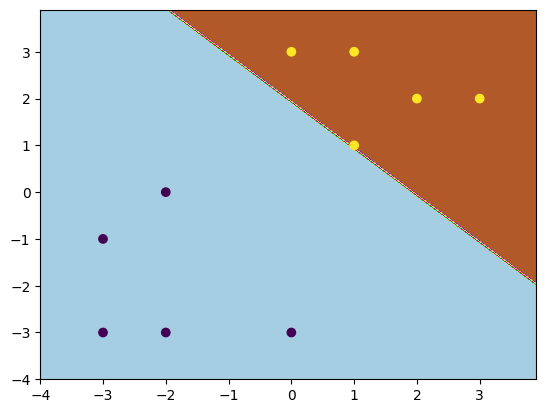

In [212]:
qnn.plot_surface_decision(x_data=x_data, y_data=y_data)

In [6]:
x_data = [[4, -2], 
        [4, 2], 
        [3, 0],
        [6, -3],
        [-4, 2],
        [-4, -2],
        [-3, 1],
        [-7, -4],
        [7, 3],
        [-6, 1],
    

        [0, -3], 
        [1, -4], 
        [-2, -5], 
        [5, -8], 
        [-5, -9], 
        [4, 7], 
        [0, 3], 
        [-4, 6], 
        [-1, 7],
        [2, 6]
        ]

y_data = [[-10], [-10], [-10], [-10], [-10], [-10], [-10], [-10], [-10], [-10], [10], [10], [10], [10], [10], [10], [10], [10], [10], [10]]

(-10.0, 10.0)

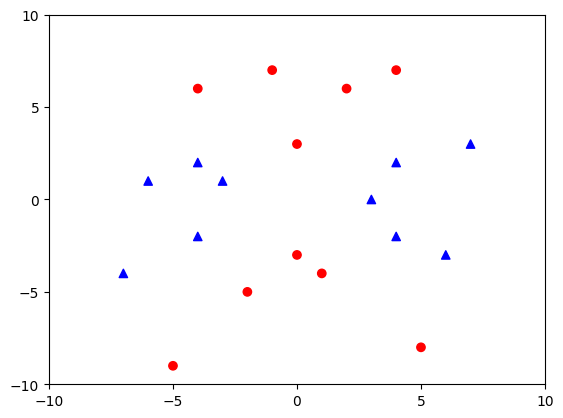

In [7]:
import matplotlib.pyplot as plt
x1_data = [i[0] for i in x_data]
x2_data = [i[1] for i in x_data]
color = {-10: "blue", 10: "red"}
y_map = [color[i[0]] for i in y_data]
marker = {"blue": 'o', "red": '^'}
y_marker = [marker[i] for i in y_map]
        

plt.scatter(x1_data[:10], x2_data[:10], c=y_map[:10], marker='^')
plt.scatter(x1_data[10:], x2_data[10:], c=y_map[10:], marker='o')
plt.xticks([-10, -5, 0, 5, 10])
plt.yticks([-10, -5, 0, 5, 10])
plt.xlim([-10, 10])
plt.ylim([-10, 10])

# MNIST Classification

In [4]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = np.reshape(X, (X.shape[0], 28, 28))

In [5]:
num1, num2 = 6, 7
x_data, y_data = [], []
y_map = {num1: -1, num2: 1}

for x_, y_ in zip(X, y):
    if int(y_) == num1 or int(y_) == num2:
        x_data.append(x_)
        y_data.append(y_map[int(y_)])

x_data = np.array(x_data)
y_data = np.array(y_data)

assert(x_data.shape[0] == y_data.shape[0])

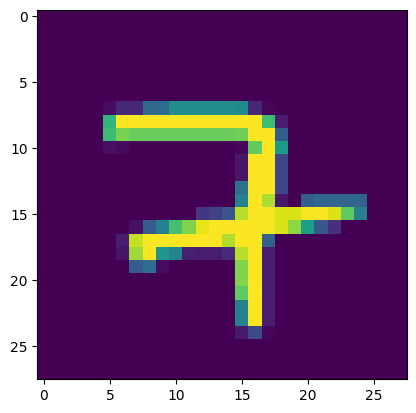

In [16]:
plt.imshow(x_data[6], cmap='viridis')
plt.show()

In [38]:
x_train = []
x_train2 = []
y_train = []
N = 20
first_pass = -1
idx = 0
i = 0

while(i < N):
    if (y_data[idx] != first_pass):
        idx += 1
        continue
    if (i == N//2 - 1):
        first_pass = 1

    i += 1
    image = block_reduce(x_data[idx], block_size=(14, 14), func=np.mean)
    x_train2.append(image.astype(int).flatten())
    image /= 5.0
    image = image.astype(int)

    x_train.append(image.flatten())
    y_train.append(y_data[idx])
    

y_train = np.reshape(y_train, (len(y_train), 1))

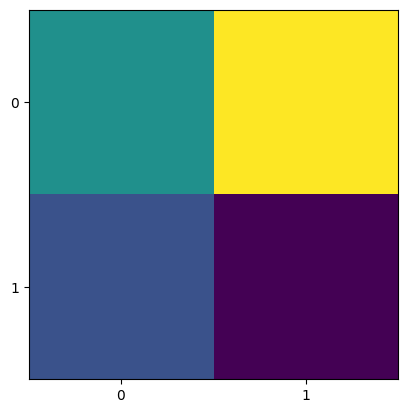

In [54]:
plt.imshow(x_train[11].reshape((2, 2)), cmap='viridis')
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.show()

In [24]:
x_test = []
y_test = []
test_size = 1000

for i in range(test_size):
    idx = round(np.random.uniform(1, x_data.shape[0]))
    image = block_reduce(x_data[idx], block_size=(14, 14), func=np.mean)
    image /= 5.0
    image = image.astype(int)

    x_test.append(image.flatten())
    y_test.append(y_data[idx])

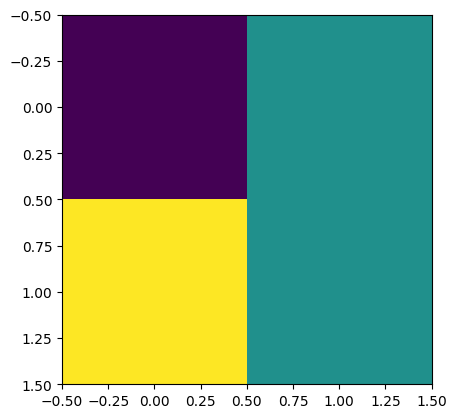

In [10]:
plt.imshow(x_train[0].reshape((2, 2)))
plt.show()

In [80]:
qubo = QNN_QUBO(N=N, L=3, H=2, n=4, m=1, P=100)

In [81]:
s = Sample(x_data=x_train, y_data=y_train, qnn=qubo, label='QNN MNIST big network ')

In [82]:
s.create_qubo(verbose=True)

In [83]:
s.run()

In [84]:
s.process_samples()

99 posibles soluciones de 133


In [86]:
s.best

Sample(sample={'W^(1)_0_0': -1.0, 'W^(1)_0_1': -1.0, 'W^(1)_0_2': 1.0, 'W^(1)_0_3': -1.0, 'W^(1)_1_0': -1.0, 'W^(1)_1_1': -1.0, 'W^(1)_1_2': 1.0, 'W^(1)_1_3': -1.0, 'W^(2)_0_0': -1.0, 'W^(2)_1_0': -1.0, 'a_0^(1_0)': 1.0, 'a_0^(1_1)': 1.0, 'a_10^(1_0)': 1.0, 'a_10^(1_1)': -1.0, 'a_11^(1_0)': 1.0, 'a_11^(1_1)': -1.0, 'a_12^(1_0)': 1.0, 'a_12^(1_1)': -1.0, 'a_13^(1_0)': 1.0, 'a_13^(1_1)': -1.0, 'a_14^(1_0)': 1.0, 'a_14^(1_1)': -1.0, 'a_15^(1_0)': 1.0, 'a_15^(1_1)': -1.0, 'a_16^(1_0)': 1.0, 'a_16^(1_1)': -1.0, 'a_17^(1_0)': 1.0, 'a_17^(1_1)': -1.0, 'a_18^(1_0)': 1.0, 'a_18^(1_1)': -1.0, 'a_19^(1_0)': 1.0, 'a_19^(1_1)': -1.0, 'a_1^(1_0)': 1.0, 'a_1^(1_1)': 1.0, 'a_2^(1_0)': 1.0, 'a_2^(1_1)': 1.0, 'a_3^(1_0)': 1.0, 'a_3^(1_1)': 1.0, 'a_4^(1_0)': 1.0, 'a_4^(1_1)': 1.0, 'a_5^(1_0)': 1.0, 'a_5^(1_1)': 1.0, 'a_6^(1_0)': 1.0, 'a_6^(1_1)': 1.0, 'a_7^(1_0)': 1.0, 'a_7^(1_1)': 1.0, 'a_8^(1_0)': 1.0, 'a_8^(1_1)': 1.0, 'a_9^(1_0)': 1.0, 'a_9^(1_1)': 1.0, 'b^(1)_0': 13.0, 'b^(1)_1': 10.0, 'b^(2)_0': 1.

In [87]:
qnn = s.decode_solution()

In [92]:
y_pred = []
for i in range(test_size):
    y_pred.append(qnn.predict(x_test[i]))
    if (y_pred[i] >= 0):
        y_pred[i] = 1
    else:
        y_pred[i] = -1

In [93]:
confusion = confusion_matrix(y_test, y_pred, normalize='true')
df_conf = pd.DataFrame(confusion).rename_axis("True Label", axis=0).rename_axis("Predicted Label", axis=1)

In [ ]:
sn.heatmap(df_conf, annot=True, cmap='crest', xticklabels=[num1, num2], yticklabels=[num1, num2])

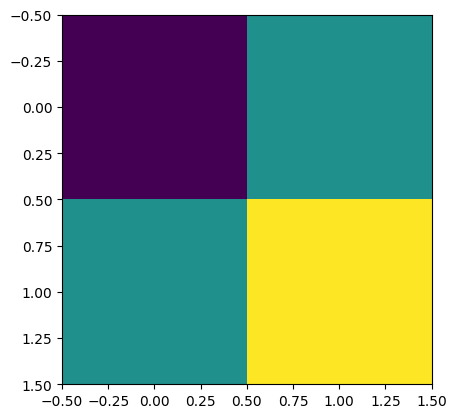

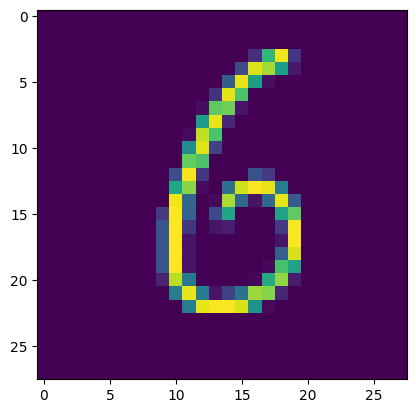

Correct -1
Predicted: -1.0


In [95]:
sample = 2

image = block_reduce(x_data[sample], block_size=(14, 14), func=np.mean)
image /= 5.0
image = image.astype(int).flatten()

plt.imshow(image.reshape((2, 2)))
plt.show()
plt.imshow(x_data[sample])
plt.show()

print(f"Correct {y_data[sample]}")
print(f"Predicted: {qnn.predict(image)}")